## BAYESIAN CLASSIFICATION and GAUSSIAN MODELS

### PART II:  Recognize Vowels from FORMANT Measurements using Gaussian Mixture Models

Purpose:  perform a simple classification task using machine learning and speech data

We make use of the Hillenbrand database and a simple Bayesian model.
We make use of the scikit-learn toolkit and our own pyspch wrapper around it for multiclass applications   
in Part II we extend to multidimensional features

### 1. Setting up your Python Environment

In [39]:
# Importing Python's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.io as sio

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git
except:
  IN_COLAB = False

from pyspch.io.hillenbrand import fetch_hillenbrand, select_hillenbrand
from pyspch.GaussianMixtureClf import GaussianMixtureClf

# installing a colorpalette and markers that can handle the 12 class data 
colors12 = ['blue','green','red','magenta','maroon', 'darkorange','steelblue', 'darkviolet', 'gold','limegreen',   'darkkhaki', 'cyan','skyblue', 
        ]
markers = ('o', 'P','v', '^', '<', '>', 'X','8', 's', '*', 'h', 'H', 'D', 'd', 'P','p')
#
cp = sns.color_palette(colors12)
sns.set_palette(cp)
#sns.palplot(cp)
# 
np.set_printoptions(precision=2)

mpl.rcParams['figure.figsize'] = [10.0, 10.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

# Pretty Print routine makes for confusion matrices
def plot_confusion_matrix(cf_mat,labels=[],cmap='Blues'):
    f,ax = plt.subplots()
    sns.heatmap(cf_mat, annot=True,fmt="d",square=True,
                annot_kws={"fontsize": 14},xticklabels=labels,yticklabels=labels,
                linecolor='k',linewidth=1.5,cmap=cmap,cbar=False)
    ax.tick_params(axis='y',labelrotation=0.0,left=True)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### 2. The Database 
All experiments in this notebook are using (parts of) the Hillenbrand '95 database. For detailed information and references: http://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt

We grab only a selection of the database with the principle measurements that can be used to do vowel recognition from psychoacoustic measurements (formants, pitch, duration).  
We drop all records with missing data.

In [40]:
hildata = fetch_hillenbrand(genders='adults',vowels='all',columns=["vowel","dur","f0","F1","F2","F3"]).dropna()
print(hildata.head())

      vowel    dur     f0     F1      F2      F3
fid                                             
m01ae    ae  323.0  174.0  663.0  2012.0  2659.0
m02ae    ae  250.0  102.0  628.0  1871.0  2477.0
m03ae    ae  344.0   99.0  605.0  1812.0  2570.0
m04ae    ae  312.0  124.0  627.0  1910.0  2488.0
m06ae    ae  254.0  115.0  647.0  1864.0  2561.0


### 3. Data Exploration

In this task we have multiple features that we can select from to build our classififier.
First task is to decide which ones to use.

Scatter plots may give us an insight as to which features are most relevant.
We can make a simple scatter plot with 2 preselected features, or can make a gridplot containing a collection of scatter plots for a getter overview

#### Tasks & Questions (1)
1. What do the scatter plots tell you.  Are there features that must be retained or others that can surely be dropped ?
2. Try to rank the features in order of importance for this 12 vowel classification task

<AxesSubplot:xlabel='F1', ylabel='F2'>

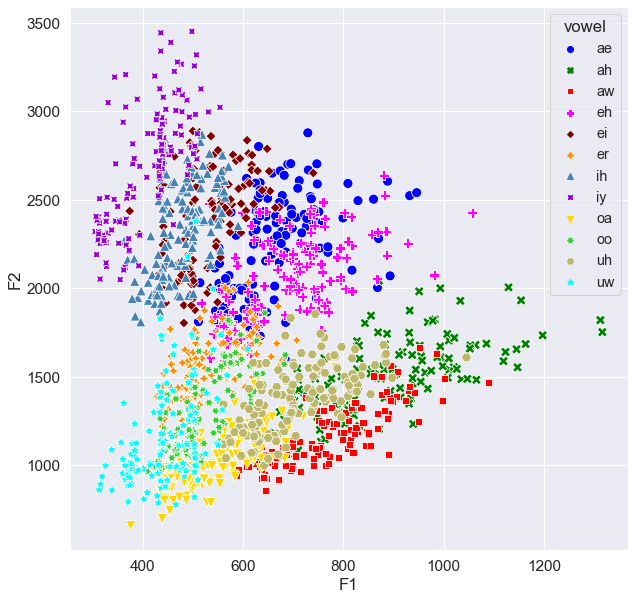

In [49]:
# a simple scatter plot with 2 selected features
# the categgories can be shown as hue(color) or style(marker)
f=plt.figure() 
sns.scatterplot(x='F1',y='F2',data=hildata,hue="vowel",style="vowel",s=100)

<Figure size 720x720 with 0 Axes>

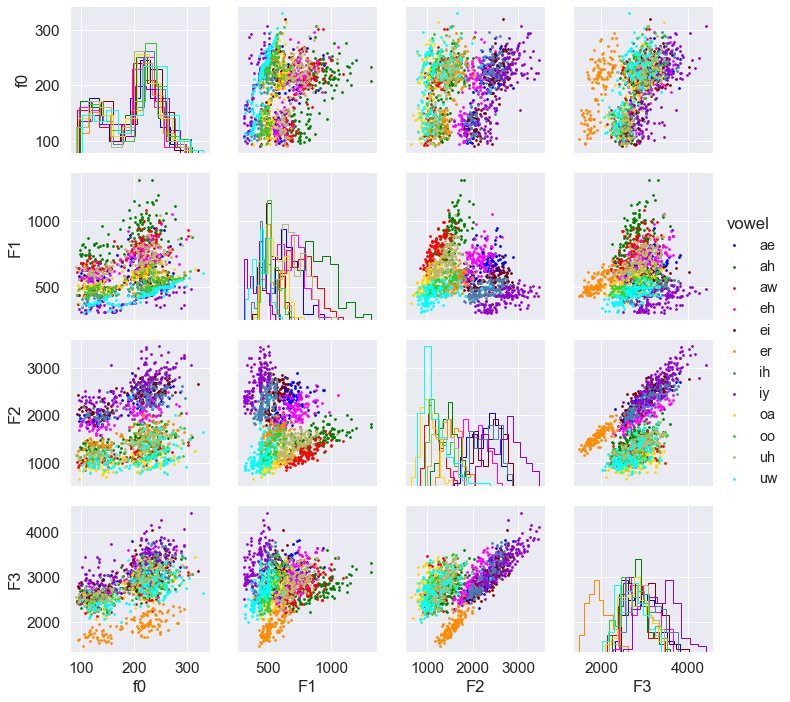

In [50]:
# if you find 12 classes too overwhelming, you can do a selection of vowels
#  in the select_hillenbrand() routine you can give a list of vowels ; with specifying 'all' there will be no selection 
f=plt.figure()
#vowel_selection=['uw','uh','aw','ah','iy','ih']
vowel_selection = 'all'
gender_selection = 'all'
hildata = fetch_hillenbrand(genders=gender_selection,vowels=vowel_selection).dropna()
hil_select = select_hillenbrand(hildata,genders=gender_selection,vowels=vowel_selection)
g = sns.PairGrid(hil_select,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=3)
g.add_legend()

### 4. Classification using a Bayesian classifier and Gaussian Mixture Models

First select all features or a subset thereof to perform your experiment
e.g. X=np.array(hildata.loc[:,['F1','F2','F3']])  will select F1, F2 and F3 as features

Performing a recognition experiments consist of following steps
1. split the data in  training set and  test set
    -  X_train, y_train, X_test, y_test
2. train models in each class given the training data 
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data; look at overall score 
5. look more in detail to a confusion matrix (next codeblock)

Note:   
We use the class *GaussianMixtureClf* which is provided in the pyspch package.
It's user interface is similar to all classifiers in *sklearn*, the GaussianMixtureClf contains for each
class a GaussianMixture density estimator.   During inference the likelihoods are combined with the estimated (or predefined) priors to compute the class posteriors

There are a number of parameters that you may adjust in the following code blocks
- n_components:  the number of mixtures used in the Gaussian MM
- train_size:    the proportion of the data that will be used for training, the remainder is used for testing
- priors_test:   you can override the class priors during testing
- random_state:  you can modify this to have a different division between train and test sets and see if you get different results


##### Task & Questions (2)
1. Evaluate the performance for different settings in n_components (number of gaussians) 1,2,4,8 . Is there a need to change max_iter, the maximum number of iterations for EM
2. Evaluate the performance for different feature sets, [F1,F2] vs. [F1,F2,F3]
3. (optional) Go back and use a smaller database, just selecting the short vowels with 'vowels6' and do the same analysis
4. (optional) Go back and add 'dur' as a 4th feature.  Duration is temporal feature and could be complementary to the formants that are spectral features.  Where in the confusion matrix could you hope for an improvement ? 

In [51]:
# --------------
#X=np.array(hildata.loc[:,['F1','F2','F3','dur']])
X=np.array(hildata.loc[:,['F1','F2','F3']])
y=np.array(hildata.loc[:,'vowel'])
classes = np.unique(y)
n_components = 4
train_size=0.5
max_iter = 10      # maximum number of iterations in the EM algorithm
random_state=0     # sets initialization of RNG for selecting train/test data, set to None to be random
priors_test = None # should be None or a vector of type e.g. [0.8 , 0.2] expects 80% male
# --------------
# 1. select non-overlapping train and test sets
test_size=1.0 - train_size
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:3],y,test_size=test_size, random_state=random_state)
clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=max_iter)
clf_GM.fit(X_train,y_train)
# 2. print the model
clf_GM.print()
#print("Classes: ",clGM.classes_)
y_pred = clf_GM.predict(X_test,priors=priors_test)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

Class[0] (ae) with prior=0.083
-----------------------------------
0.2793654038092371 [ 720.41 2505.11 3232.93] [ 89.09  88.8  121.91]
0.3173514459344348 [ 593.18 1899.31 2571.84] [ 44.51 114.44 109.2 ]
0.302493712834028 [ 683.4  2294.6  2963.77] [ 69.54 118.91 134.7 ]
0.10078943742230033 [ 723.37 2697.46 3611.45] [ 75.82 102.99 112.12]

Class[1] (ah) with prior=0.089
-----------------------------------
0.29058768438999244 [ 952.74 1631.41 2744.59] [ 88.98 131.3  137.47]
0.428712956544365 [ 756.95 1296.58 2537.02] [ 56.39 118.45 161.71]
0.1682132456057211 [ 881.75 1452.93 2885.44] [ 72.82  94.95 131.16]
0.11248611345992142 [1080.4  1788.25 3292.66] [123.58 112.06 164.96]

Class[2] (aw) with prior=0.089
-----------------------------------
0.13915660370627023 [ 906.93 1417.92 3214.32] [ 55.14  69.69 125.29]
0.4309439150469606 [ 663.73 1039.26 2522.26] [ 38.59  68.25 174.15]
0.302113100571503 [ 784.89 1185.86 2846.02] [ 56.15  89.57 251.3 ]
0.12778638067526626 [ 845.51 1326.8  2843.54] [ 

C:\Users\compi\Anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\compi\Anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\compi\Anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\compi\Anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerat

Global Accuracy: 73.42%


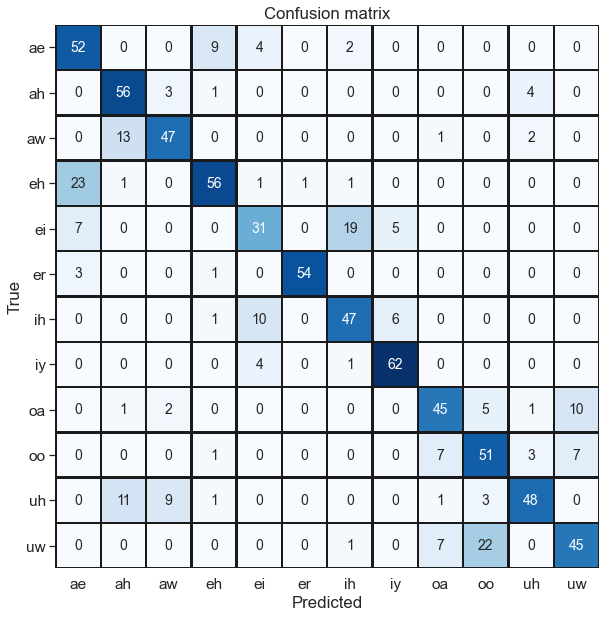

In [52]:
# A Confusion Matrix gives a more detailed image of the errors that we make
y_pred = clf_GM.predict(X_test)
cf_mat = skmetrics.confusion_matrix(y_test,y_pred)    
print('Global Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))
plot_confusion_matrix(cf_mat,labels=classes)

#### Task & Questions (3)
Given this rather limited database, we may prefer a cross_validation style evaluation

1. Evaluate the performance for different settings in n_components (number of gaussians) 1,2,4,8 . Is there a need to change max_iter, the maximum number of iterations for EM
2. Evaluate the performance for different feature sets, [F1,F2] vs. [F1,F2,F3]
   use X for all features X[:,0:2] for features F1 and F2  or X[:,i] for a single feature with i for feature 0..2  or also [:,[0,1,3]] for a combination of F1,F2 and duration 
3. Change the number of folds in the crossvalidation between 2, 5 and 10.  Is there a trend in the
recognition scores ?  Is this to be expected and what does it tell you about the size of the database ?
4. (optional) Go back and use a smaller (easier) database, just selecting the short vowels with 'vowels6' and do the same analysis


In [53]:
n_components = 1
nfold_options = [4] # [5,10,2]
ftr_options = [ ['F1','F2','F3'], ['F1','F2'], ['F2','F3'], ['F2'] , ['F1']]
for ftrs in ftr_options:
    print('Features: ',ftrs)
    X=np.array(hildata.loc[:,ftrs])
    clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=20)
    for nfolds in nfold_options:
        scores = cross_val_score(clf_GM, X, y, cv=nfolds)
        print("Average Cross validation score for %d folds: %.2f %% correct" % (nfolds,100.0*np.average(scores)))

Features:  ['F1', 'F2', 'F3']
Average Cross validation score for 4 folds: 54.37 % correct
Features:  ['F1', 'F2']
Average Cross validation score for 4 folds: 50.97 % correct
Features:  ['F2', 'F3']
Average Cross validation score for 4 folds: 33.47 % correct
Features:  ['F2']
Average Cross validation score for 4 folds: 26.11 % correct
Features:  ['F1']
Average Cross validation score for 4 folds: 22.70 % correct
